The Market Basket Analysis is an unsupervised model that examines and quantifies relationships between products. It is based on the concept of affinity. Affinity refers to an association rule that indicates the relationship between products. In this context, likelihood represents the probability or chance that if a customer purchases certain products, they are also likely to purchase other related products.
When ranking affinities, importance refers to the significance or relevance of a particular affinity between products. It is a measure of how strongly the association between two products influences customers' purchasing behavior. The importance of an affinity can be determined based on factors such as the frequency of co-occurrence, the support or confidence level of the association rule, or other statistical measures that assess the strength of the relationship.

I import the libraries and the data I need

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from google.colab import drive
drive.mount('/content/gdrive')
data=pd.read_csv("/content/gdrive/MyDrive/prod_ord.csv")


Mounted at /content/gdrive


The data contains informations regarding the orders. In fact there are several facts concerning the transactions made by the customer as the: store_id, product class, purchase price and so on.

In [ ]:
data

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,23,23,49,35551922,1,125.40,0.0,2022-10-04 18:28:51,6
1,23,23,49,30344384,1,8.30,0.0,2022-10-04 18:28:51,6
2,23,23,49,33794292,1,1.99,0.0,2022-10-04 18:28:51,6
3,23,23,49,33795776,1,5.10,0.0,2022-10-04 18:28:51,6
4,23,23,49,36235381,1,76.05,0.0,2022-10-04 18:28:51,6
...,...,...,...,...,...,...,...,...,...
916995,934581,934581,29,35508942,1,33.60,0.0,2023-04-30 19:35:53,2
916996,934620,934620,44,36237691,1,11.99,0.0,2023-04-30 19:19:55,13
916997,934620,934620,44,81259479,1,9.99,0.0,2023-04-30 19:19:55,13
916998,934660,934660,46,34067775,1,1.90,0.0,2023-04-30 19:32:17,9


I check for the number of refunds

In [ ]:
len(data[data['direction']==-1])

30719

There are 30719 refunds on 917000 transactions

Evaluating the most purchased products

In [ ]:
data.product_class[data['direction']==1].value_counts(normalize=True)

3     0.289621
11    0.144864
10    0.122910
7     0.090228
13    0.066512
4     0.054990
6     0.047443
9     0.047096
2     0.030207
1     0.028722
14    0.028588
12    0.017445
8     0.016318
5     0.015056
Name: product_class, dtype: float64

As we can see the products of the clas 3  are the ones with the highest number of purchases

Evaluating which is the products with the high frequency in the transactions

In [ ]:
data.product_id[data['direction']==1].value_counts(normalize=True)

33700716    0.041733
33817091    0.018464
34843564    0.009362
32882024    0.004873
35209202    0.003634
              ...   
35805126    0.000025
32093992    0.000024
81259510    0.000021
36560713    0.000014
48010326    0.000011
Name: product_id, Length: 2000, dtype: float64

The most purchased product is the 33700716

The data contains informations concerning the purchases and the refunds made by several customers in different date. Furthermore there are also the informations regarding the product as the product_id and the product class.

I consider only the purchases, I discard the refunds transactions.
I convert the variable purchase_datetime into date and I create a new variable that contains the day of the week referred to the purchase date.

In [ ]:
# New column for the day of the week
only_purchases=data[data['direction']==1]
only_purchases['purchase_datetime']=pd.to_datetime(only_purchases['purchase_datetime'])
only_purchases['week_day'] = only_purchases['purchase_datetime'].dt.day_name()


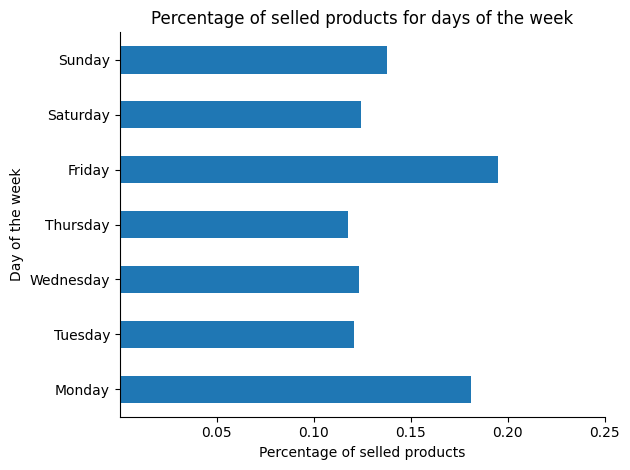

In [ ]:
#Counts of purchased products per week-day.
conteggio_per_giorno = only_purchases['week_day'].value_counts(normalize=True).sort_index()

# Creating the barplot
fig, ax = plt.subplots()
conteggio_per_giorno.plot(kind='barh', ax=ax)

# X labels
giorni_della_settimana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_yticklabels(giorni_della_settimana)
valori_x = [0.05, 0.10, 0.15, 0.20, 0.25]
ax.set_xticks(valori_x)

# Fix tbe labels and the title, I remove the right and top spines for a better visualization
ax.set_ylabel('Day of the week')
ax.set_xlabel('Percentage of selled products')
ax.set_title('Percentage of selled products for days of the week')
ax.spines[['right', 'top']].set_visible(False)

# Showing the plot
plt.tight_layout()
plt.show()

As we can see the majority of the products is purchased on Friday, while on Thursday there is about the 12% of the total purchases.

I create a new variable for the purchase time

In [ ]:
# I create a new column for the purchase time
only_purchases['selling_hour'] = only_purchases['purchase_datetime'].dt.hour

range_hours = [ (4, 8), (8, 12), (12, 16), (16, 20), (20, 24)]

# Counts of selled products for hour range
conteggio_per_range = []
for start, end in range_hours:
    selling_per_range = only_purchases.loc[(only_purchases['selling_hour'] >= start) & (only_purchases['selling_hour'] < end)]
    conteggio_per_range.append(len(selling_per_range))


I evaluate the proportions in terms of purchase products for hour range.

In [ ]:
conteggio_per_range
# Total sum
totale = sum(conteggio_per_range)
#Proportion
proporzioni = np.divide(conteggio_per_range, totale)

# Print proportions
print(proporzioni)


[0.01149748 0.24216135 0.30892798 0.38653768 0.05087551]


16-20 is the time range with the highest frequency of purchases

I group the data on the basis of the order and the purchase date.

In [ ]:
# I group the  orders on  the basis of the order_id  and the purchase_datetime
data=data[data['direction']==1]
transactionData = data[['order_id', 'purchase_datetime', 'product_id']]
transactionData['order_id']=transactionData['order_id'].astype(str)
transactionData['product_id']=transactionData['order_id'].astype(str)

transactionData = transactionData.groupby(['order_id', 'purchase_datetime'])['product_id'].apply(lambda x: ','.join(x)).reset_index()
new=transactionData.copy()
transactionData.drop(['order_id', 'purchase_datetime'], axis=1, inplace=True)

transactionData.to_csv('transactionData.csv', index=False)


In [ ]:
grouped_data = data.groupby('order_id')['product_id'].agg(lambda x: list(set(x))).reset_index()


The variable grouped_data contains the list of the products purchased in each order.

In [ ]:
grouped_data

,order_id,product_id
0,23,"[81268736, 36501640, 32157580, 35165452, 35411..."
1,30,"[35075523, 35649740, 48500403, 35765324]"
2,32,"[35661570, 36475845, 31047366, 33700716, 48081..."
3,48,"[35661955, 32990860, 33766040, 81250201, 32448..."
4,50,"[33892572, 32469444, 35567966, 33000436]"
...,...,...
104129,934484,"[33817091, 31993381, 34252904, 31087273, 36507..."
104130,934581,[35508942]
104131,934620,"[36237691, 81259479]"
104132,934660,[34067775]


The objective of Market Basket Analysis is to identify and construct typical market baskets by discovering and highlighting the most significant and influential affinities among products. By analyzing customer purchase data, this technique allows businesses to uncover patterns and associations that can inform various aspects of their operations, such as product placement, cross-selling strategies, and targeted marketing campaigns.

I convert data into an appropriate form for the analysis

In [ ]:
# Converting the data
newdata=grouped_data['product_id']
te = TransactionEncoder()
te_ary = te.fit(newdata).transform(newdata)
df = pd.DataFrame(te_ary, columns=te.columns_)



In Market Basket Analysis, frequent itemsets are sets of items that occur together with a certain level of frequency or support within a dataset. Frequent itemsets help identify patterns and associations between products in a transactional dataset as this one. They are determined with the use of methodologies as the Apriori algorithm.
The Apriori algorithm is a method used in Market Basket Analysis to find frequent itemsets and generate association rules. It involves some steps:
1. Set a minimum support threshold to determine what qualifies as a frequent itemset.
2. Generate candidate itemsets by combining frequent itemsets of length k-1.
3. Scan the dataset to count the occurrences of each candidate itemset.
4. Remove itemsets that do not meet the minimum support threshold.
5. Generate association rules based on the frequent itemsets.
6. Calculate the confidence level of each association rule.
7. Eliminate weak rules that do not meet a minimum confidence threshold.
8. Repeat the process by generating candidate itemsets, scanning the dataset, pruning infrequent itemsets, and generating association rules until no new frequent itemsets or association rules are found.

Consequently it helps in the identification of patterns among the products.

In this following chunk I use the apriori algorithm with a support of 0.01 and I sort the result in a descending order.

In [ ]:
# Computing the frequent itemsets
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True).sort_values("support",ascending=False).reset_index(drop=True)
print("Itemset frequenti:")
print(frequent_itemsets)



Itemset frequenti:
      support              itemsets
0    0.234515            (33700716)
1    0.118492            (33817091)
2    0.065656            (34843564)
3    0.047890  (33817091, 33700716)
4    0.035445            (32882024)
..        ...                   ...
115  0.010026            (34130894)
116  0.010026            (30329663)
117  0.010016            (33995213)
118  0.010016  (32078970, 32078935)
119  0.010006  (33700716, 36128141)

[120 rows x 2 columns]


The itemset that contains the product "33700716" presents the highest support(0.23).

Association rules are a result of the Market Basket Analysis and represent relationships between items or products based on their co-occurrence in transactions. They consist in two parts:
- Antecedent: This is the item or set of items that appear on the left-hand side of the rule. It represents the condition or premise of the rule.

- Consequent: This is the item or set of items that appear on the right-hand side of the rule. It represents the items that are likely to be associated with the antecedent.

The rules are derived with the use of
- support: the support of a rule measures the proportion of transactions in the dataset that contain both the antecedent and the consequent.
-confidence: confidence measures the conditional probability that the consequent is purchased given that the antecedent is purchased. It is calculated as the ratio of the support of the rule to the support of the antecedent.
> Another important quantity is the Lift.
> It measures the strength of the association between the antecedent and the consequent. It indicates how much more likely the consequent is to be purchased when the antecedent is present compared to its individual probability of occurrence.



I restrict to product associations with confidence > 0.5,the confidence threshold is employed to select the most probable product associations and filter out less significant ones.

In [ ]:
# Generating the association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

I print the first ten association rules

In [ ]:
pd.set_option('expand_frame_repr', False)
print(rules.head(10))


  antecedents consequents  antecedent support  consequent support   support  confidence       lift  leverage  conviction
0  (32079082)  (32079103)            0.019417            0.020570  0.015374    0.791790  38.493133  0.014975    4.704057
1  (32079103)  (32079082)            0.020570            0.019417  0.015374    0.747432  38.493133  0.014975    3.882455
2  (32079103)  (32078935)            0.020570            0.019321  0.013694    0.665733  34.455982  0.013296    2.933818
3  (32078935)  (32079103)            0.019321            0.020570  0.013694    0.708748  34.455982  0.013296    3.362822
4  (32079082)  (32078935)            0.019417            0.019321  0.012455    0.641444  33.198877  0.012080    2.735079
5  (32078935)  (32079082)            0.019321            0.019417  0.012455    0.644632  33.198877  0.012080    2.759346
6  (32078795)  (32079103)            0.015480            0.020570  0.011994    0.774814  37.667820  0.011676    4.349426
7  (32079103)  (32078795)       

In [ ]:
rules[rules['confidence'] > 0.5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(32079082),(32079103),0.019417,0.020570,0.015374,0.791790,38.493133,0.014975,4.704057
1,(32079103),(32079082),0.020570,0.019417,0.015374,0.747432,38.493133,0.014975,3.882455
2,(32079103),(32078935),0.020570,0.019321,0.013694,0.665733,34.455982,0.013296,2.933818
3,(32078935),(32079103),0.019321,0.020570,0.013694,0.708748,34.455982,0.013296,3.362822
4,(32079082),(32078935),0.019417,0.019321,0.012455,0.641444,33.198877,0.012080,2.735079
5,(32078935),(32079082),0.019321,0.019417,0.012455,0.644632,33.198877,0.012080,2.759346
6,(32078795),(32079103),0.015480,0.020570,0.011994,0.774814,37.667820,0.011676,4.349426
7,(32079103),(32078795),0.020570,0.015480,0.011994,0.583100,37.667820,0.011676,2.361525
8,(31618405),(34129942),0.016921,0.017314,0.011725,0.692963,40.022718,0.011432,3.200540
9,(34129942),(31618405),0.017314,0.016921,0.011725,0.677205,40.022718,0.011432,3.045519


I define a function to delete the redundant rules. A "redundant association rule" refers to a rule that conveys the same information as another rule or rules in a given dataset. These redundant rules do not provide any additional insights or knowledge beyond what is already expressed by other rules.
In practice a rule is redundant if there are more
general rules (same RHS, less items in
the LHS) with same or higher
confidence

In [ ]:
def find_redundant_rules(rules):
    redundant_rules = []

    for i in range(len(rules)):
        rule1 = rules.iloc[i]
        antecedent1 = rule1['antecedents']
        consequent1 = rule1['consequents']
        confidence1 = rule1['confidence']

        for j in range(i+1, len(rules)):
            rule2 = rules.iloc[j]
            antecedent2 = rule2['antecedents']
            consequent2 = rule2['consequents']
            confidence2 = rule2['confidence']

            if consequent1 == consequent2 and set(antecedent1).issubset(set(antecedent2)) and confidence1 >= confidence2:
                redundant_rules.append(rule2)

    return redundant_rules




In [ ]:
find_redundant_rules(rules)

[]

I select the first ten association rules in terms of lift.

In [ ]:
dataframe_sorted = rules.sort_values('lift', ascending=False)

# Seleziona i primi 10 valori dalla colonna ordinata
top_10_values = dataframe_sorted.head(10)


In [ ]:
top_10_values

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
28,(32079082),"(32078795, 32079103)",0.019417,0.011994,0.010746,0.553412,46.140155,0.010513,2.212345
27,"(32078795, 32079103)",(32079082),0.011994,0.019417,0.010746,0.895917,46.140155,0.010513,9.421137
26,"(32079082, 32079103)",(32078795),0.015374,0.015480,0.010746,0.698938,45.150885,0.010508,3.270159
29,(32078795),"(32079082, 32079103)",0.015480,0.015374,0.010746,0.694169,45.150885,0.010508,3.219506
25,"(32079082, 32078795)",(32079103),0.011620,0.020570,0.010746,0.924793,44.959120,0.010507,13.023195
30,(32079103),"(32079082, 32078795)",0.020570,0.011620,0.010746,0.522409,44.959120,0.010507,2.069512
17,"(32079082, 32078935)",(32079103),0.012455,0.020570,0.011111,0.892059,43.367708,0.010854,9.073723
20,(32079103),"(32079082, 32078935)",0.020570,0.012455,0.011111,0.540149,43.367708,0.010854,2.147534
19,(32079082),"(32078935, 32079103)",0.019417,0.013694,0.011111,0.572206,41.785464,0.010845,2.305562
18,"(32078935, 32079103)",(32079082),0.013694,0.019417,0.011111,0.811360,41.785464,0.010845,5.198182


For example there is an association between product 32079082 and the products:(32078795, 32079103).Marketing campaigns can be created to leverage these associations. For example: Buy the first product and get a discount on the second product.

<ipython-input-25-d35976eb667e>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Lift')


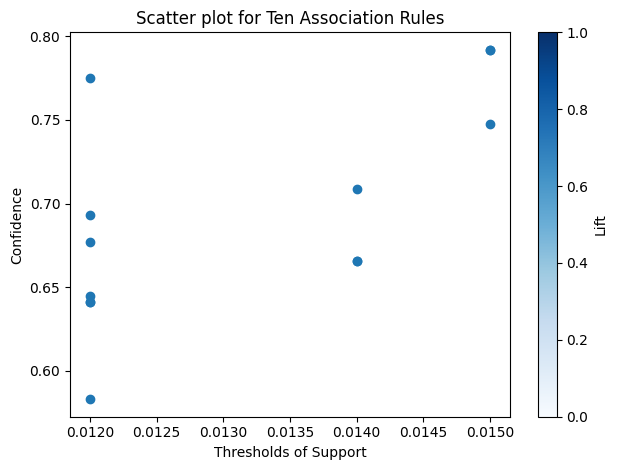

In [ ]:
# I filter the association rules to a value for confidence higher than 50%
sub_rules = rules[rules['confidence'] > 0.5].head(10)
order_sub_rules = sub_rules["support"].round(3).unique()


# Get the corresponding confidence and lift values for the selected support values
confidence_values = []
lift_values = []
to_plot=[]
for sup in order_sub_rules:
    rule = sub_rules[sub_rules['support'].round(3) == sup]
    confidence_values.append(rule['confidence'].iloc[0])
    lift_values.append(rule['lift'].iloc[0])
    to_plot.append((sup,rule['confidence'].iloc[0]))
# Adjusting color intensity based on lift
max_lift = max(lift_values)
normalized_lift = lift_values / max_lift
colors = plt.cm.Blues(normalized_lift)

for sup in order_sub_rules:
    rule = sub_rules[sub_rules['support'].round(3) == sup]
    confidence_values = np.concatenate((confidence_values, rule['confidence'].values))
    order_sub_rules = np.concatenate((order_sub_rules, np.full(len(rule), sup)))

plt.scatter(order_sub_rules, confidence_values)

plt.xlabel("Thresholds of Support")
plt.ylabel("Confidence")
plt.title("Scatter plot for Ten Association Rules")

# Add a colorbar and legend for the lift values
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Lift')

plt.tight_layout()
plt.show()



I prepare the data also for the network graph

In [ ]:
itemsets=[]
for i in range(0, 19):
    antecedent = list(sub_rules.antecedents.loc[0])[0]
    consequent = list(sub_rules.consequents.loc[0])[0]
    t = (antecedent, consequent)
    itemsets.append(t)


 the code  below generates a visual representation of a directed graph using NetworkX, with node labels, circular layout, custom node color, and arrows indicating the direction of the edges.

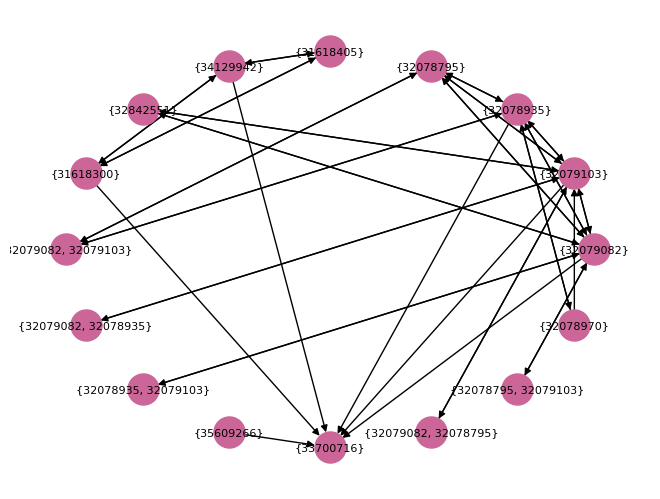

In [ ]:
import networkx as nx
new=pd.DataFrame(rules)
# I create a graph from the asoociation rules
G=nx.from_pandas_edgelist(new,"antecedents","consequents", create_using=nx.DiGraph())
new_labels={}
for node in G.nodes:
  label=str(node).replace("frozenset","").replace('(','').replace(')','')
  new_labels[node]=label
pos=nx.circular_layout(G)
nx.draw(G,pos,labels=new_labels,with_labels=True, node_size=500, font_size=8, node_color=(0.8,0.4,0.6),arrows=True)

